# Desarrollo
## Avances
- Cargadas las señales en formato MNE y preprocesadas, falta revisar si funciona correctamente

## Conclusiones
- Hay que ver como cargar el archivo de montage para MNE.

In [68]:
#LIBRERÍAS

#Librerías de Sistema
import os
import sys
import time

#Librerías de Manejo de Datos
import pandas as pd
import numpy as np
import scipy.signal as sgn
import scipy.stats as sts
from numbers import Number #usando isinstance(X, Number) puedo detectar si X es una variable numerica de cualquier tipo

#Librerías de Interfaz
from tkinter import filedialog
from tkinter import *
from tkinter import messagebox
from tkinter import ttk

#Librerías para EEG
import mne

#Librerías para Plotings
import matplotlib.pyplot as plt

import plotly.graph_objs as go
import plotly.offline as py
import plotly

#Widgets de Jupyter
from ipywidgets import interactive, HBox, VBox, widgets, interact, HTML

py.init_notebook_mode(connected = True) #Estableciendo modo Offline para Plotly

#Procesamiento
from sklearn.decomposition import FastICA

### Variables Globales 

In [69]:
#Definir Layouts para Plotly

#Layout para plot en tiempo
time_layout = go.Layout(title = "Will be changed in each plot",
                        xaxis = dict(title = 'Time [s]',
                                     rangeslider = dict(visible = True,
                                                        yaxis = dict(rangemode = 'auto'
                                                                    )
                                                        )
                                    ),
                        yaxis = dict(title = 'Amplitude [uV]',
                                     fixedrange = False)
                       )

#Layout para plot en frecuencia
freq_layout = go.Layout(title = "Will be changed in each plot",
                        xaxis = dict(title = 'Frequecy [Hz]',
                                     range = [0, 60],
                                     rangeslider = dict(visible = True,
                                                        yaxis = dict(rangemode = 'auto'
                                                                    )
                                                        )
                                    ),
                        yaxis = dict(title = 'Amplitude [uV]',
                                     fixedrange = False)
                       )

#Layout para plot de espectrograma
spec_layout = go.Layout(title = "Will be changed in each plot",
                        xaxis = dict(title = 'Time [s]'
                                    ),
                        yaxis = dict(title = 'Frequency [Hz]',
                                     range = [0, 60],
                                     fixedrange = False)
                       )

### Funciones

In [70]:
#Función utilizada para obtener los índices de elementos de una lista

get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]

#This would work like : X = ["Mario", "Luigi", "Yoshi", "Mario"]
#print(get_indexes("Mario", X)) -> Out: [0,3]
#print(get_indexes("Luigi", X)) -> Out: [1]

In [71]:
#Función utilizada para generar una ventana que haga una pregunta "Sí/No"

def yn_quest(quest):
    yn_quest_win = Tk()
    
    answer = messagebox.askquestion("QUESTION:",quest)
    yn_quest_win.destroy()
    
    yn_quest_win.mainloop()
    
    return answer


In [72]:
#Función usada para cargar la señal

def load_signal():   
    nom_s = input("Which will be the signal name? ") #Pedimos el nombre de la señal

    while True:
        search_signal_win = Tk()                                             #Crea el ambiente de interfaz TK
        xs = filedialog.askopenfilename(title = "Select Signal File :",          #Dice que va a sacar la variable xs como el filename de un archivo
                                        filetypes = (("Documento de texto","*.txt"),
                                                     ("Excel (post 2003)", ".xlsx"),
                                                     ("Excel (prev 2003)", ".xls"),
                                                     ("Todos los archivos","*.*")
                                                    )                        #Con titulo de ventana y opciones de abrir archivos de ese tipo
                                       )

        search_signal_win.destroy()   #Destuimos el ambiente de Tk luego de utilizada la ventana
        search_signal_win.mainloop()  #Establecemos que la ventana quede abierta hasta que se de una respuesta

        print (xs)

        #Detección de tipo de archivo, en este momento el programa sólo puede leer archivos txt y excel
        if ".txt" in xs:
            opt = yn_quest('Is it a file exported by the OpenBCI Software?') #Si es txt, puede haber sido exportado por OpenBCI o no
            if opt == 'Yes' or opt == 'yes':
                XS, col_names, col_types, usecols, skiprows, sep = openbci_topd(xs)
            else:
                XS, col_names, col_types, usecols, skiprows, sep = csv_topd(xs)
            print("Signal Loaded. TXT format.")
            break
        
        elif ".xlsx" in xs or ".xls" in xs:
            XS, col_names, col_types, usecols, skiprows, sep = excel_topd(xs, interval = False)
            print("Signal Loaded. Excel format.") #Esto sería reemplazado por la función "leer txt" que tomaría la dirección y parámetros como Cantidad de columnas, Nombres de columnas, etc (o se puede probar con la direccion sola y si no funciona pedir parametros)
            break

        #Si la persona presiona cancelar, en xs se carga un "", por lo que usamos esa condición     
        elif xs == "":
            print("Cancelled Operation")
            break  #Al presionar cancelar salimos del loop que abre la ventana de seleccion de archivo

        #Si se selecciona un archivo que no sea txt o excel, se aclara que el formato no era correcto, pero no sale del loop
        else:
            print("Wrong File Format. Try Again.")
    
    return XS, nom_s, col_names, col_types, usecols, skiprows, sep

In [73]:
#Función que transforma un txt (CSV) en DataFrame (tabla) de Pandas

def csv_topd(truepath):
    
    #Creamos un loop que pruebe cargar el archivo CSV con una cierta configuración, y sino solicite los datos nuevamente
    while True:
        col_names, col_types, usecols, skiprows, sep = col_rows_sep()         #Función que solicita al usuario ingresar los datos necesarios para cargar el archivo CSV
        
        try:
            X = pd.read_csv(truepath,  sep=sep, skiprows=skiprows, names=col_names, usecols=range(usecols), lineterminator = '\n')
        
        #Testeamos que los valores ingresados en las columnas de tipo "Channel", "Accel" y "Tag" (que son las que vamos a usar) sean numericas, en realidad solo esta testeando que el primer valor de dicahs columnas sea numerica, tenemos que ver si podemos mejorarlo
            for j in range(len(col_types)):
                if col_types[j] == "Channel" or col_types[j] == "Tag" or col_types[j] == "Accel":
                    assert isinstance(X.values[0,j], Number) and pd.notnull(X.values[0,j]) == True
 
        
        except AssertionError:
            print("\n\nThere's a non-numerical value in a column corresponding to Channel, Accel, or Tag, which should be numerical")
        
        except:
            print('\n\nThe input parameters do not match. Please enter them again.\n\n')
            
        else:
            save_opt = input('Do you wish to save this configuration?: ') #Todavía no lo implementamos, está de recordatorio, sería poder guardar la configuración de parámetros de carga de un archivo para poder usarla luego
            break
    
    X.col_names = col_names #Esto sería medio de gusto si ahora col_names y col_types son globales, pero quedó.
    X.col_types = col_types
    
    return X, col_names, col_types, usecols, skiprows, sep

In [74]:
#Función que transforma un txt (CSV) exportado por OpenBCI en DataFrame (tabla) de Pandas

def openbci_topd(truepath):
        
    selecc_predet = yn_quest('Will you use the default OpenBCI configuration?') #Esta opción setea los parámetros de carga a los que usa OpenBCI predeterminadamente, que se ven abajo
    
    if selecc_predet == 'No' or selecc_predet == 'no': #si decide que no, el usuario ingresa los parámetros a utilizar para la carga
        col_names, col_types, usecols, skiprows, sep = col_rows_sep()
        
    elif selecc_predet == 'Yes' or selecc_predet == 'yes': #si decide que si, los parámetros utilizados son los siguientes
        
        sep = ","  #Coma como separador de columnas
        col_names = ['Sample', 'Ch1', 'Ch2', 'Ch3', 'Ch4', 'x', 'y', 'z', 'Time', ' '] #Nombre de las columnas
        col_types = ['Misc', 'Channel', 'Channel', 'Channel', 'Channel', 'Accel', 'Accel', 'Accel', 'Time', 'Misc'] #Tipo de valores que contiene cada columna
        usecols = 10
        skiprows = 6

    while True:        
                
        try:
            X = pd.read_csv(truepath,  sep=sep, skiprows=skiprows, names=col_names, usecols=range(usecols), lineterminator = '\n')
        
        #Testeamos que los valores ingresados en las columnas de tipo "Channel", "Accel" y "Tag" (que son las que vamos a usar) sean numericas, en realidad solo esta testeando que el primer valor de dicahs columnas sea numerica, tenemos que ver si podemos mejorarlo
            for j in range(len(col_types)):
                if col_types[j] == "Channel" or col_types[j] == "Tag" or col_types[j] == "Accel":
                    assert isinstance(X.values[0,j], Number) and pd.notnull(X.values[0,j]) == True
        
        except AssertionError:
            
            print("\n\nThere's a non-numerical value in a column corresponding to Channel, Accel, or Tag, which should be numerical")
            
            col_names, col_types, usecols, skiprows, sep = col_rows_sep()         #Función que solicita al usuario ingresar los datos necesarios para cargar el archivo CSV
                
        except:
            print('\n\nThe input parameters do not match. Please enter them again.\n\n')
            
            col_names, col_types, usecols, skiprows, sep = col_rows_sep()         #Función que solicita al usuario ingresar los datos necesarios para cargar el archivo CSV
            
        else:
            if selecc_predet == 'No' or selecc_predet == 'no':
                save_opt = input('Do you wish to save this configuration?: ') #Todavía no lo implementamos, está de recordatorio, sería poder guardar la configuración de parámetros de carga de un archivo para poder usarla luego
            break 
    
    return X, col_names, col_types, usecols, skiprows, sep

In [75]:
#Función que transforma un Excel en DataFrame (tabla) de Pandas, dicho excel puede contener la señal o los datos de los intervalos

def excel_topd(truepath, interval = True): #La segunda variable, interval, define si el arvhivo excel a leer es de intervalos o de señal
    
    while True:
        #Si es un excel de intervalos, se pregunta si dicho excel tiene una columna de Endpoint o de duracion de los intervalos, y sino se solicita que el usuario ingrese un valor de duración general para todos los intervalos
        if interval == True:
            
            header = 0
            index_col = 0
            usecols = 3
            skiprows = 0
            col_names = ['Number', 'Name', 'Startpoint']

            endpoint_opt = yn_quest("Does it has an endpoint column?")
            if endpoint_opt == 'Yes' or endpoint_opt == 'yes':
                col_names.append('Endpoint')
                usecols = usecols + 1

            else:
                duration_opt = yn_quest("Does it has a duration column?")
                if duration_opt == 'Yes' or duration_opt == 'yes':
                    col_names.append('Duration')
                    usecols = usecols + 1
                    
        #Si no es un excel de intervalos se usa la función col_rows_sep para definir los parametros de carga
        elif interval == False:
            header = None
            index_col = None
            col_names, col_types, usecols, skiprows, sep = col_rows_sep()
        
        try:
            X = pd.read_excel(truepath, usecols = range(usecols), skiprows = skiprows, names = col_names, header=header, index_col=index_col)
            
            #Testeamos que los valores ingresados en las columnas de tipo "Channel", "Accel" y "Tag" (que son las que vamos a usar) sean numericas, en realidad solo esta testeando que el primer valor de dicahs columnas sea numerica, tenemos que ver si podemos mejorarlo
            if interval == False:
                for j in range(len(col_types)):
                    if col_types[j] == "Channel" or col_types[j] == "Tag" or col_types[j] == "Accel":
                        assert isinstance(X.values[0,j], Number) and pd.notnull(X.values[0,j]) == True
        
        except AssertionError:
            print("\n\nThere's a non-numerical value in a column corresponding to Channel, Accel, or Tag, which should be numerical")
        
        except:
            print('\n\nThe input parameters do not match. Please enter them again.\n\n')
        
        else:
            break
    
    if interval == True:
        return X
    elif interval == False:
        return X, col_names, col_types, usecols, skiprows, None

In [76]:
def col_rows_sep():
    
    def accept_col(columnas, col_n, col_t, window):
        window.destroy()
                
        col_names = []
        col_types = []
        
        for i in range(columnas.get()): 
            col_names.append(col_n[i].get()) #El comando get permite obtener de una variable Tk a una variable numpy que se pueda leer numericamente
            col_types.append(col_t[i].get())
            
        return col_names, col_types
                            
    def selec_pd (columnas): #Función llevada a cabo al presionar aceptar en la ventana selec_pd_win       
        
        #Primero levantamos una ventana para confirmar los valores seleccionados
        conf = messagebox.askquestion("Confirm","Will you select : " + str(columnas.get()) + " columns & " + str(filas.get()) + " rows?")
        if conf == "yes":
                        
            #Si se confirman los valores, se destruye la ventana selec_pd_win, y se abre una ventana para dar nombres y tipos a cada columna
            selec_pd_win.destroy()
            
            col_names_win = Tk()
            
            col_params = []
            col_n = []
            col_t = []
            col_names_win.title("Columns")
            col_names_win.label1 = Label(col_names_win, text = "Name:").place(x=30,y=20)
            col_names_win.label2 = Label(col_names_win, text = "Type:").place(x=170,y=20)
            
            col_names_win.geometry("350x"+str(40+columnas.get()*35))
            for i in range(columnas.get()):
                col_n.append(StringVar())
                col_t.append(StringVar())
                col_names_win.entry = Entry(col_names_win, textvariable=col_n[i]).place(x=30 , y=40+i*26)
                col_names_win.spinbox = Spinbox(col_names_win, values = ("Channel", "Misc", "Tag", "Time", "Accel"), wrap =True, textvariable =col_t[i]).place(x=170 , y=40+i*26)
            col_names_win.button1 = Button (col_names_win , text="Accept", 
                                            command=lambda: col_params.append(accept_col(columnas, col_n, col_t, col_names_win))).place(x=100, y=40+26*columnas.get()) #command= imprimir)
            col_names_win.mainloop()
            
            return col_params[0]
        
    selec_pd_win = Tk() #En este punto comienza la función, creando la ventana de interfaz
    
    col_params = []
    
    #Creamos variables tk para los valores de cantidad de columnas, filas y separador
    columnas = IntVar()
    filas = IntVar()
    separador = StringVar()
    
    #Damos las características de la ventana, titulo, tamaño y componentes(botones, espacios de input, etc)
    selec_pd_win.title("Set parameters for Pandas" ) 
    selec_pd_win.geometry("350x200")

    selec_pd_win.label1 = Label(selec_pd_win , text= "Rows to Skip:").place(x=30,y=20)
    selec_pd_win.entry1 = Entry(selec_pd_win, textvariable=filas).place(x=170 , y=20)

    selec_pd_win.label2 = Label(selec_pd_win, text="Columns to use:").place(x=30 , y=60)
    selec_pd_win.entry2 = Entry(selec_pd_win, textvariable=columnas).place(x=170 , y=60)

    selec_pd_win.label3 = Label(selec_pd_win, text="Separator to use:").place(x=30 , y=100)
    selec_pd_win.entry3 = Entry(selec_pd_win, textvariable=separador).place(x=170 , y=100)
    
    #Al presionar el boton de aceptar, se activa la función selec_pd
    selec_pd_win.button1 = Button (selec_pd_win , text="Accept", 
                                   command=lambda: col_params.append(selec_pd(columnas))).place(x=170 , y=150) #command= imprimir)

    selec_pd_win.mainloop()
    
    return col_params[0][0], col_params[0][1], columnas.get(), filas.get(), separador.get()

In [77]:
#Función para seleccionar que canalaes se quieren utilizar, y qué posición tiene cada uno

def chan_config(col_names, col_types):
    
    predet_1020_montage = mne.channels.read_montage("standard_1020")
    predet_1020_montage.ch_names.sort()
    
    def selec_chan(chan_s, chan_p):
        chan_pos = []
        chan_selecc = []
        
        chan_selec_win.destroy()
        for i in range(chan_quant):
            chan_pos.append(chan_p[i].get())
            chan_selecc.append(chan_s[i].get())
            
        return chan_pos, chan_selecc
    
    chan_quant = 0
    chan_all = []
    chan_p = []
    chan_s = []
    
    chan_params = []
    
    i = 0
    for word in col_types:
        if word == 'Channel':
            chan_all.append(col_names[i])
            chan_quant += 1
        i += 1

    chan_selec_win = Tk()
    chan_selec_win.title("Channel Selection")
    chan_selec_win.label1 = Label(chan_selec_win, text = str(chan_quant) +' Channels were detected, which ones will you use?').place(x=30,y=10)
    
    chan_selec_win.geometry("500x"+str(80+chan_quant*35))
    for i in range(chan_quant):
        chan_s.append(IntVar())
        chan_p.append(StringVar())

        chan_selec_win.label2 = Label(chan_selec_win, text = chan_all[i] + " column:").place(x=20 , y=40+i*26)
        chan_selec_win.check1 = Checkbutton(chan_selec_win, text = "Import?", variable=chan_s[i], onvalue=1, offvalue=0).place(x=90 , y=40+i*26)
        chan_selec_win.label3 = Label(chan_selec_win, text = "Channel Position:").place(x=180 , y=40+i*26)
        chan_selec_win.Combobox1 = ttk.Combobox(chan_selec_win , values = predet_1020_montage.ch_names , textvariable = chan_p[i] ).place(x=300 , y=40+i*26)

    chan_selec_win.button1 = Button (chan_selec_win , text="Accept Channels", 
                                     command= lambda: chan_params.append(selec_chan(chan_s, chan_p))).place(x=100, y=60+26*chan_quant) #command= imprimir)

    chan_selec_win.mainloop()
    
    active_chan_pos =[]
    active_chan_names = []
    
    for i in get_indexes(1, chan_params[0][1]):
        
        active_chan_pos.append(chan_params[0][0][i])
        active_chan_names.append(chan_all[i])
            
    return chan_params[0][0], chan_quant, chan_params[0][1], len(active_chan_names), active_chan_names, active_chan_pos

In [78]:
#Función que transforma la variable Pandas de la cual se leyó la señal previamente, en un arreglo Numpy

def pd_toarray(X_pd):
    
    i = 0
    j = 0
    chan_list = []
    accel_list = []
    tag_list = []
    
    #Leyendo las columnas del archivo pandas
    while i < X_pd.shape[-1]:
        
        #guardaremos aquellas del tipo Channel en una variable
        if col_types[i] == "Channel":
            if chan_selecc[j] == 1:
                chan_list.append(X_pd.columns[i])
            j += 1
        
        #las del tipo Accel en otra, por si en algún momento sirve utilizar los datos del acelerómetro
        if col_types[i] == " Accel":
            accel_list.append(X_pd.columns[i])
        
        #y en otra variable las del tipo Tag, para cuando se necesiten para definir intervalos
        if col_types[i] == "Tag":
            tag_list.append(X_pd.columns[i])
        i += 1

    X_chan = (X_pd.filter(chan_list)).values
    X_accel = (X_pd.filter(accel_list)).values
    X_tag = (X_pd.filter(tag_list)).values
    
    return X_chan, X_accel, X_tag

In [79]:
def select_onecol(col_type, many_col_index):

    def set_onecol_action(many_col_index, selection):           

        column = many_col_index[selection.get()]

        select_onecol_win.destroy()

        return column

    select_onecol_win = Tk()
    select_onecol_win.title("Too many columns of " + col_type + " type")
    select_onecol_win.geometry("350x150")
    Label(select_onecol_win , text ="Select which one shall be used to detect Sample Rate").pack(side="top")

    selection = IntVar()
    column = []
    
    for i in range(len(many_col_index)):

        Radiobutton(select_onecol_win , variable=selection, value=i).place(x=300,y=30 + 20*i)
        Label(select_onecol_win , text = str(col_names[many_col_index[i]])).place(x=10,y=30 + 20*i)

    Button(select_onecol_win , text="Accept", command= lambda: column.append(set_onecol_action(many_col_index, selection))).place(x=150, y= 50 + 20*len(many_col_index))

    select_onecol_win.mainloop()
    
    return column[0]

In [80]:
#Función que define la frecuencia de muestreo fundamental (sample_rate)

def find_samplerate(X_pd):
    
    time_col_index = get_indexes("Time", col_types)
    
    if len(time_col_index) > 1:
        
        time_col_index = [select_onecol("Time", time_col_index)]
    
    if len(time_col_index) == 1: #Algorithm to try to detect the sample rate from the Time type column
        
        try:
            
            assert(":" in X_pd.values[0, time_col_index[0]])
            
        except:
            
            freq_detect = 1 / (float(X_pd.values[1, time_col_index[0]]) - float(X_pd.values[0, time_col_index[0]])) 
        
        else:
            
            (hh0, mm0, ss0) = X_pd.values[0, time_col_index[0]].split(":")
            (hh1, mm1, ss1) = X_pd.values[1, time_col_index[0]].split(":")
            t0 = 3600 * float(hh0) + 60 * float(mm0) + float(ss0)
            t1 = 3600 * float(hh1) + 60 * float(mm1) + float(ss1)
            
            if (t1-t0) != 0:
                freq_detect = 1 / (t1-t0)
            
            else:
                time_col_index = []
            
    samplerate_win = Tk()
    samplerate_opt = IntVar()
    samplerate_entry = DoubleVar()
    
    sample_rate_params = []

    def freqw_destroy (samplerate_opt, samplerate_entry, freq_detect):
        
        if samplerate_entry.get() != 0 and samplerate_entry.get() != 0.0:
            samplerate_opt.set(1)

        if samplerate_opt.get() == 0 :
            samplerate_conf = messagebox.askquestion("Confirm","Will you select " + str(freq_detect) + " Hz (detected)?")
            sample_rate = freq_detect
            
        elif samplerate_opt.get() == 1 :
            samplerate_conf = messagebox.askquestion("Confirm","Will you select " + str(samplerate_entry.get()) + " Hz (entered)?")
            sample_rate = samplerate_entry.get()
            
        if samplerate_conf == "yes":
            samplerate_win.destroy()
            
        return sample_rate

    samplerate_win.title("Set sample rate" ) 
    samplerate_win.geometry("350x150")

    if len(time_col_index) == 1:
        
        Radiobutton(samplerate_win , variable=samplerate_opt , value=0).place(x=300,y=30)
        samplerate_win.label1 = Label(samplerate_win , text = ' The detected sample rate is ' + str (freq_detect) + ' Hz').place(x=10,y=30)

    if len(time_col_index) == 0: #If there's more than one column with the Time type, then it conflicts with automated detection of samplerate - should be changed later to conflict when there's no Time columns, but when there are more than one, should be choosable
        
        samplerate_win.label1 = Label(samplerate_win , text = ' No Time type columns, unable to detect SampleRate.').place(x=10,y=30)
        samplerate_opt.set(1)
    
    if len(time_col_index) > 1:
        
        samplerate_win.label1 = Label(samplerate_win , text = ' Too many columns with Time type, no SampleRate detection.').place(x=10,y=30)
        samplerate_opt.set(1)
    
    Radiobutton(samplerate_win , variable=samplerate_opt , value=1).place(x=300,y=70)
    samplerate_win.label2 = Label(samplerate_win , text = ' Enter manually : ').place(x=10,y=70)
    samplerate_win.entry1 = Entry(samplerate_win , textvariable= samplerate_entry ).place(x=130 , y=70)

    samplerate_win.button1 = Button(samplerate_win , text="Accept", 
                                    command=lambda: sample_rate_params.append(freqw_destroy(samplerate_opt, samplerate_entry, freq_detect))).place(x=150, y=110)

    samplerate_win.mainloop()
    
    return sample_rate_params[0]

In [81]:
#Función que transforma arreglo Numpy en formato MNE, que nos permitirá manipular datos EEG, EMG, etc

def array_tomneRaw(X_chan):
    
    ch_names = []
    #montage = []

    for i in get_indexes(1,chan_selecc):
        ch_names.append('Ch'+ str(i+1))
        #montage.append(chan_pos[i])   No funciona así, porque hay que darle una variable montage especifica, hay que ver como crearla
    
    #Debemos crear una variable con la información de la señal, nombre y tipo de los canales, y posición
    X_mneinfo = mne.create_info(ch_names = ch_names, 
                                ch_types = 'eeg', 
                                #montage = montage,  ver como crear el montage https://martinos.org/mne/dev/generated/mne.channels.Montage.html#mne.channels.Montage
                                sfreq = sample_rate) 
    
    #Creamos la variable MNE, transponiendo la matriz de datos numpy ya que MNE posiciona los canales como filas
    #Se puede acceder a la información dentro de la variable MNE a traves de sus atributos X_mneRaw.get_data(), X_mneRaw.ch_names(), etc
    X_mneRaw = mne.io.RawArray(np.transpose(X_chan), info = X_mneinfo)
    
    return X_mneRaw 

In [82]:
def array_tomneEvoked(signal, zeros_fill): #zeros_fill activa la función para que complete con ceros, ya que, como montage no 
    #funciona bien, por más que usemos 4 canales tenemos que pasarle toda la configuracion 10-20 para que haga bien el mapa 
    #topografico, entonces completamos los canales que faltan hasta completar la configuracion con lineas de ceros, supuestamente
    #son 97 canales en 10-20, pero hay cuatro que estan repetidos así que los borramos y quedan 93.
    
    if zeros_fill == True:
        predet_1020_montage = mne.channels.read_montage('standard_1020', unit = "m")
        
        #---------------------------------------------------------------------------------------------------------------------
        #en el montage 1020 que ofrece MNE predeterminadamente, algunas posiciones se encuentran repetidas,
        #idealmente habría que recrear el montage corrigiendo dichas posiciones, pero lo que hacemos por ahora es elegir entre
        #esas repetidas una o la otra
        duplicate_list = []
        
        if ("T7" in active_chan_pos):
            duplicate_list.append("T3")
        else:
            duplicate_list.append("T7")
            
        if ("T8" in active_chan_pos):
            duplicate_list.append("T4")
        else:
            duplicate_list.append("T8")
            
        if ("P7" in active_chan_pos):
            duplicate_list.append("T5")
        else:
            duplicate_list.append("P7")
            
        if ("P8" in active_chan_pos):
            duplicate_list.append("T6")
        else:
            duplicate_list.append("P8")

        noduplicate_coord = predet_1020_montage.pos.copy()
        noduplicate_pos = predet_1020_montage.ch_names.copy()

        for i in duplicate_list:
            j = get_indexes(i, noduplicate_pos)[0]

            del noduplicate_pos[j]
            noduplicate_coord = np.delete(noduplicate_coord, j, axis = 0)

        #Cuando se modifique el montage para que no tenga repetidas, toda esta parte entre comentarios no iria, solo iria 
        #de aca en adelante
        #------------------------------------------------------------------------------------------------------------------
        
        alt_montage = mne.channels.Montage(pos = noduplicate_coord,
                                        ch_names = noduplicate_pos,
                                        selection = np.arange(len(noduplicate_pos)),
                                        kind = 'standard_1020')

        alt_montage.plot()

        X_superchan = np.zeros([len(noduplicate_pos), signal.shape[-1]])

        for i in range(active_chan_quant):

            for j in range(len(noduplicate_pos)):

                if active_chan_pos[i] == noduplicate_pos[j]:
                    X_superchan[j,:] = signal[i,:].copy()

        alt_mneinfo = mne.create_info(ch_names = noduplicate_pos,
                                        ch_types = 'eeg', 
                                        montage = alt_montage,  
                                        sfreq = sample_rate) 

        alt_mneEvoked = mne.EvokedArray(X_superchan, alt_mneinfo)
        
        return alt_mneEvoked
    
    elif zeros_fill == False:
        
        return None #No implementamos todavia crear un evoked con un montage propio

In [83]:
def tag_interval(tag_colindex):

    int_ini_sample = []
    int_end_sample = []
    int_ini = []
    int_end = []
    
    int_name = []
    int_quant = 0
    
    a = X_pd.values[:, tag_colindex]

    tags = np.unique(a)

    tag_names = []

    for t in tags:

        print("Which is the name for the tag '" + str(t) + "' \n")
        tag_name = input("Entry:")
        tag_names.append(tag_name)

        first = True
        n = 1
        for i in range(a.shape[0]):

            if a[i] ==  t and first == True:

                int_ini_sample.append(i)
                int_name.append(tag_names[get_indexes(t, tags)[0]] + " " + str(n)) #Podriamos hacer que los nombres de los intervalos sean ej: Ojos Cerrados (10-20 seg), Ojos Cerrrados(40-60 seg) en vez de Ojos Cerrados 1, Ojos Cerrados 2
                int_quant += 1
                n = n + 1

                first = False

            elif a[i] != t and first == False:

                int_end_sample.append(i-1)
                first = True

            elif a[i] == t and i == (a.shape[0]-1):
                int_end_sample.append(i)

    for i in int_ini_sample:
        int_ini.append(float(i/sample_rate))
        
    for e in int_end_sample:
        int_end.append(float(e/sample_rate))
        
    return int_ini, int_end, int_name, int_quant

In [84]:
#Función que permite definir los intervalos a utilizar, con nombres, inicios y finales

def interval_choice ():  
    
    int_quant = 0
    int_name= []
    int_ini= []
    int_end= []

    if len(get_indexes("Tag", col_types)) > 0:
        
        tag_int_opt = yn_quest("Type Tag Column Detected, do you wish to use it to define Intervals?")
    
    else:
        
        tag_int_opt = "no"
    
    if tag_int_opt == "Yes" or tag_int_opt == "yes":
        
        tag_col_index = get_indexes("Tag", col_types)
        
        if len(tag_col_index) > 1:
            
            tag_col_index = [select_onecol("Tag", tag_col_index)]
            
        int_ini, int_end, int_name, int_quant = tag_interval(tag_col_index)
        excel_int_opt = "no"
    
    else:
        
        excel_int_opt= yn_quest("Do you wish to load an excel file with intervals?")
    
    #Si el usuario desea, se puede cargar un archivo de excel con los intervalos ya definidos
    if excel_int_opt == "Yes" or excel_int_opt == "yes":  
        
        search_int_win = Tk() #Crea la ventana root
        int_path = filedialog.askopenfilename(title = "Select Signal File :",          #Dice que va a sacar la variable Xs como el filename de un archivo
                                        filetypes = (("Excel (post 2003)", ".xlsx"),
                                                     ("Excel (prev 2003)", ".xls"),
                                                     ("All files","*.*")
                                                    ) #Con titulo de ventana y opciones de abrir archivos de ese tipo
                                       ) 
        search_int_win.destroy()
        
        int_pd = excel_topd(int_path)
        
        int_quant = int_pd.shape[0]
        
        for i in range(int_quant):
        
            int_name.append(int_pd.values[i,0])
            int_ini.append(int_pd.values[i,1])
            
            if 'Endpoint' in int_pd.columns:
                int_end.append(int_pd.values[i,2])
            
            elif 'Duration' in int_pd.columns:
                int_end.append(int_pd.values[i,1] + int_pd.values[i,2])
            
            else:
                if i == 0:
                    int_durat = int(input("How long did the intervals last (in sec)?: "))
                int_end.append(int_pd.values[i,1] + int_durat)
        
        search_int_win.mainloop()
    
    #Si no, se pueden definir manualmente
    elif excel_int_opt == "No" or excel_int_opt =="no" and tag_int_opt == "No" or tag_int_opt == "no":
        
        before_scat = []
    
        for j in range(active_chan_quant):
            before_scat.append(go.Scatter(x = X_mneRaw.times,
                                          y = X_mneRaw.get_data()[j, :] + 100*(j+1)
                                         )
                              )

        before_fig = go.Figure(data = before_scat ,
                               layout = time_layout
                              )

        py.plot(before_fig)

        #time.sleep(0.5) #We set it to wait for the plot to be done, and the we ask how many intervals to analyze
        
        int_quant = int(input("How many interval will you analyze?: "))
        i = 0

        #Stablish names and sizes
        while i < int_quant:
            print("Name for the interval no. ", (i+1))
            int_name.append(input())
            #Solicito al usuario los rangos de tiempo para cada intervalo
            print("Start time for interval " + int_name [i] , end ="\n")
            int_ini.append(float(input('Enter in secs: '))) 
            print("End time for interval " + int_name [i] , end ="\n")
            int_end.append(float(input('Enter in secs: '))) 
            #Multiplico esos tiempos por la frecuencia de submuestreo, para obtener la cantidad de muestras que quiero ver
            
            i = i + 1
            
    print(int_name)
    print(int_ini)
    print(int_end)
    
    return int_ini, int_end, int_name, int_quant
    
#A futuro: implementar una funcipon que permita guardar un excel con los intervalos cargados manualmente, y otra función que defina los intervalos a partir de los tags

In [85]:
def interval_sec_tosample():
    
    int_ini_sample = []
    int_end_sample = []
    
    for i in range(int_quant):
        sample_ini= int(int_ini[i]*(fq_sub))
        sample_end= int(int_end[i]*(fq_sub))

        int_ini_sample.append(sample_ini)
        int_end_sample.append(sample_end)
        
    return int_ini_sample, int_end_sample

In [86]:
#Función para definir los parámetros de preprocesado

def preproc_params():
    
    #Selección del tipo de filtro, Chebyschev o Butterworth
    def filter_window_destroy():
        filter_window.destroy()
        
        return filter_opt.get(), filt_order.get(), fq_lo.get(), fq_hi.get(), fq_no.get(), rs_cheby.get() , rp_cheby.get()      
    
    filter_window = Tk()    
    filter_window.title("Setting parameters for Filtering" ) 
    filter_window.geometry("370x330")
    
    filter_opt = StringVar()
    filt_order = IntVar()
    fq_lo = IntVar()
    fq_hi = IntVar()
    fq_no = IntVar()
    fq_sub = IntVar()
    rs_cheby = DoubleVar()
    rp_cheby = DoubleVar()
    
    filter_params = []
    filter_opt.set("Butterworth")
    
    filter_window.Combobox1 = ttk.Combobox(filter_window , values = ("Butterworth", "Chebyschev"), textvariable = filter_opt).place(x=30 , y=20)
    
    filter_window.label1 = Label(filter_window , text = ' Enter Filter Order : ').place(x=10, y=50)
    filter_window.entry1 = Entry(filter_window , textvariable = filt_order ).place(x=200 , y=50)
    
    filter_window.label2 = Label(filter_window , text = ' Enter Low Frequency : ').place(x=10, y=80)
    filter_window.entry2 = Entry(filter_window , textvariable = fq_lo ).place(x=200 , y=80)
    
    filter_window.label3 = Label(filter_window , text = ' Enter High Frecuency : ').place(x=10, y=110)
    filter_window.entry3 = Entry(filter_window , textvariable = fq_hi ).place(x=200 , y=110)
    
    filter_window.label4 = Label(filter_window , text = ' Enter Filter Notch : ').place(x=10, y=140)
    filter_window.entry4 = Entry(filter_window , textvariable = fq_no ).place(x=200 , y=140)
    
    filter_window.label6 = Label(filter_window , text = ' COMPLETE THE NEXT PARAMETERS ONLY FOR CHEBYSCHEV FILTER').place(x=10, y=170)
    
    #if filter_opt.get() == "Chebyschev" : #buscar que el cambio en en combobox sea un comando que actualice si se pone el entry para la ganancia o no
    filter_window.label6 = Label(filter_window , text = ' Enter Atenuatuion for Chebyshev :').place(x=10, y=200)
    filter_window.entry6 = Entry(filter_window , textvariable = rs_cheby ).place(x=200 , y=200)
    
    filter_window.label7 = Label(filter_window , text = ' Enter Ripple for Chebyshev :').place(x=10, y=230)
    filter_window.entry7 = Entry(filter_window , textvariable = rp_cheby ).place(x=200 , y=230)  
    
    filter_window.button1 = Button(filter_window , text="Accept", command=lambda: filter_params.append(filter_window_destroy())).place(x=165, y=280)
    #filter_window.button2 = Button(filter_window , text="Apply", command=lambda: filter_params.append(filter_window_destroy())).place(x=165, y=280)
    
    filter_window.mainloop()
    
    return filter_params[0][0], filter_params[0][1], filter_params[0][2], filter_params[0][3], filter_params[0][4], filter_params[0][5] , filter_params[0][6] 

In [87]:
#Función para el preprocesado de la señal X_mneRaw

def sgn_preproc(X_mneRaw):
    
    if filt_type == 'Butterworth':
        typ = "butter"
        rs = None
        rp = None
        
    if filt_type == 'Chebyschev':
        typ = "cheby1"
        if cheby_rs == 0:
            rs = 60
        else:
            rs = cheby_rs
        
        if cheby_rp == 0 :
            rp = 2
        else :
            rp = cheby_rp
    
    if filt_order == '':
        order = 5
    else:
        order = int(filt_order)
    
    #Si no se ingresa nada, se supone que no se usará frecuncia de corte inferior (filtro pasabajo)
    if fq_lo == '':
        low = None
    else:
        low = float(fq_lo)
    
    #Si no se ingresa nada, se supone que no se usará frecuncia de corte superior (filtro pasaalto)
    if fq_hi == '':
        high = None
    else:
        high = float(fq_hi)
    
    #Creamos una copia de la señal, sino al tratar de filtrarla, filtraremos tambien la señal Raw
    filtered_signal = X_mneRaw.copy()
    
    #Este if significaría que si al menos una de las dos (fq_hi o fq_lo) tiene valor, entonces aplicamos filtro
    if low != None or high != None:
        filtered_signal.filter(l_freq = low,
                               h_freq = high,
                               method = 'iir',
                               iir_params = dict(order = order,
                                                 ftype = typ,
                                                 rs = rs,
                                                 rp = rp
                                                )
                            )
    
    #Si ambas son None, no filtramos
    else:
        print('No Bandpass Filter applied')
    
    #Si no se ingresa nada, se supone que no se usará filtro Notch
    if fq_no == '':
        notch = None
    else:
        notch = float(fq_no)
    
    if notch != None:
        filtered_signal.notch_filter(freqs = notch,
                                    notch_widths = 1,
                                    method = 'iir',
                                    iir_params = dict(order = filt_order,
                                                      ftype = "butter"
                                                     )
                                    )
    
    else:
        print('No Notch Filter applied')
    
    #Solicitamos la frecuencia de submuestreo
    
    message = str(sample_rate) + ' Hz is the main sample rate, would you like to Subsample?'
    
    while True:
        fq_sub_opt = yn_quest(message)
        
        if fq_sub_opt == "yes" or fq_sub_opt == "Yes":
            
            fq_sub = input("Insert Subsample Frequency (Must be lower than "  + str(sample_rate) + "): ")
            
            if float(fq_sub) < sample_rate:
                fq_sub = float(fq_sub)
                filtered_signal.resample(sfreq = fq_sub)
                break
            
            else:
                message = 'Entered Subsample Frequency is greater than the Manin Sample Rate, would you like to subsample?'
        
        if fq_sub_opt == "no" or fq_sub_opt == "No":
            
            fq_sub = float(sample_rate)
            break
    
    return filtered_signal, fq_sub
                
    
#    #Si no se ingresa nada, se supone que no se usará Submuestreo
#    if fq_sub != '' and fq_sub != str(sample_rate) and fq_sub != str(int(sample_rate)):
#        fq_sub = float(fq_sub)
#        filtered_signal.resample(sfreq = fq_sub)
#        return filtered_signal
#    else:
#        fq_sub = sample_rate
#        return filtered_signal

In [88]:
def sgn_reref(signal):
    
    def apply_ponderation(signal):
        
        array = signal.get_data()
        
        inc = []
        channels = []
        
        for i in range(active_chan_quant):
            inc.append(include_list[i].get())
            print(pound_list[i].get())
            
        print(inc)
        print(array)
        
        lap = array[0, :].copy() * 0
        avg = 0
        
        for j in get_indexes(1, inc):
            lap = lap + (pound_list[j].get()) * array[j,:] 
            avg += 1
            
            channels.append(active_chan_names[j])
            
        lap = lap / avg
        
        print(lap)
        
        for i in range(active_chan_quant):
            array[i,:] = array[i,:] - lap
        
        print(array)
        print(channels)
        
        newsignal = array_tomneRaw(np.transpose(array)) #Transponemos array porque en la funcion arraytomneRaw vuelve a transponerse
        newsignal = mne.set_eeg_reference(newsignal, ref_channels=[])
        
        return newsignal
    
    def choose_reref_type(signal):
            
        if reref_type.get() == "No Rereferencing":
            newref_signal = mne.set_eeg_reference(signal, ref_channels=[])
            
        if reref_type.get() == "Common Average Reference":
            newref_signal = mne.set_eeg_reference(signal, ref_channels='average')
            
        if reref_type.get() == "Reference from Channel Combination":
            newref_signal = apply_ponderation(signal)
            
        reref_window.destroy()
        
        return newref_signal
    
    reref_window = Tk()
        
    signal_list = []
    
    pound_params = []
    pound_list = []
    include_list = []
    
    reref_window.geometry("600x" + str(60 + 28*active_chan_quant))
    
    reref_type = StringVar()
    reref_type.set("No Rereferencing")
    reref_window.Combobox1 = ttk.Combobox(reref_window , values = ("No Rereferencing", "Common Average Reference", "Reference from Channel Combination"), textvariable = reref_type ).place(x=30 , y=20)
    reref_window.title("Would you like to stablish a new reference point?" ) 
    
    reref_window.label1 = Label(reref_window, text = "Select which Channels to Create Reference from, and insert each Ponderation:").place(x=180 , y=10)
    
    for i in range(active_chan_quant):
        pound_list.append(DoubleVar())
        include_list.append(IntVar())
        
        pound_list[i].set(1.0)
        reref_window.label = Label(reref_window, text = active_chan_names[i] + " - " + active_chan_pos[i] + " Ponderation:").place(x=200 , y=40+i*26)
        reref_window.entry = Entry(reref_window , textvariable = pound_list[i]).place(x=340 , y=40+i*26)
        reref_window.check = Checkbutton(reref_window , text = "Include?" , variable= include_list[i] , onvalue= 1, offvalue= 0).place(x=470 , y=37+i*26)
    
    reref_window.Button1 = Button (reref_window , text="Apply Reference", command=lambda: signal_list.append(choose_reref_type(signal))).place(x=50, y=70)
    
    reref_window.mainloop()
    
    return signal_list[0][0]

In [89]:
def sgn_ica(signal):
    
    restored_array = np.transpose(signal.get_data())
    
    def plot_ica(interv):
        
        i = get_indexes(interv.get(), int_names)[0]
        
        #Plotteamos la señal
        signal_scat = []
        
        for j in range(active_chan_quant):
            signal_scat.append(go.Scatter(x = signal.times[int_ini_sample[i] : int_end_sample[i]],
                                          y = signal.get_data()[j,int_ini_sample[i] : int_end_sample[i]] + 100*j,
                                          name = "Channel " + str(j)
                                          )
                               )
        
        signal_fig = go.Figure(data = signal_scat, layout = time_layout)
        
        signal_fig.layout.title = "Time Spectrum for Signal at Interval " + int_names[i]
        
        py.plot(signal_fig)
        
        time.sleep(5)
        
        #Obtenemos los componentes para ese intervalo
        
        ica = FastICA(n_components=active_chan_quant, 
                  max_iter = 100 , 
                  tol = 20
                  )
        
        components = ica.fit_transform(np.transpose(signal.get_data()[:, int_ini_sample[i] : int_end_sample[i]]))
        
        #Visualizamos los componentes

        components_scat = []

        for j in range(active_chan_quant):
            
            plot_components = components[:,j] + 0.1*j
            components_scat.append(go.Scatter(x = signal.times[int_ini_sample[i] : int_end_sample[i]],
                                              y = plot_components,
                                              name = "Component " + str(j)
                                             )
                                   )

        components_fig = go.Figure(data = components_scat,
                                   layout = time_layout
                                  )

        components_fig.layout.title = "Time Spectrum for ICA Components of Interval " + int_names[i]

        py.plot(components_fig)

        time.sleep(2)

        #Visualizamos las transformadas de los componentes
        components_transform_scat = []

        for j in range(active_chan_quant):

            fr, tf = sgn.welch(components[:, j], 
                               fs=fq_sub, 
                                nperseg = int(fq_sub)*2, 
                                noverlap = int(fq_sub)*1,
                                scaling = "spectrum"
                              )

            components_transform_scat.append(go.Scatter(x = fr,
                                                        y = tf,
                                                        name = "Component " + str(j)
                                                       )
                                            )

        components_transform_fig = go.Figure(data = components_transform_scat,
                                            layout = freq_layout
                                            )

        components_transform_fig.layout.title = "Frequency Spectrum for ICA Components of Interval " + int_names[i]

        py.plot(components_transform_fig)
        
        return components, ica
    
    def delete_component(components, comp_d, interv, ica, restored_array):
        
        #Obtenemos los valores del arreglo components_d para borrar o dejar
        comp_list = []
        
        i = get_indexes(interv.get(), int_names)[0]
        
        for j in range(active_chan_quant):
            comp_list.append(comp_d[j].get())
        
        #Buscamos donde el arreglo de components_d vale 1, y en esos eliminamos el componente
        for d in get_indexes(1, comp_list):
            components[:, d] = 0
        
        restored = ica.inverse_transform(components)
        
        restored_array[int_ini_sample[i]:int_end_sample[i], :] = restored
        
        newsignal_scat = []
        
        for j in range(active_chan_quant):
            newsignal_scat.append(go.Scatter(x = signal.times[int_ini_sample[i] : int_end_sample[i]],
                                          y = restored_array[int_ini_sample[i] : int_end_sample[i], j]+100*j,
                                          name = "Channel " + str(j)
                                          )
                               )
        
        newsignal_fig = go.Figure(data = newsignal_scat, layout = time_layout)
        
        newsignal_fig.layout.title = "Time Spectrum for Cleaned Signal at Interval " + int_names[i]
        
        py.plot(newsignal_fig)
        
        return restored_array
    
    def close_win(win):
        
        win.destroy()
    
    ica_win_list = []
    ica_win_list2 = []
    ica_win_list2.append(restored_array)
    
    component_d = []
    comp_win_list = []
    
    ica_win = Tk()
    selected_interv = StringVar()
    ica_win.title("ICA Analysis")
    ica_win.label1 = Label(ica_win, text = 'Select Interval to Analyse: ').place(x=120,y=10)

    ica_win.geometry("500x" + str(60 + 26*active_chan_quant))
    
    for i in range(active_chan_quant):

            component_d.append(IntVar())
            ica_win.check = Checkbutton(ica_win ,  text =  "Component no " + str(i) , variable= component_d[i] , onvalue= 1, offvalue= 0).place(x=300 , y=20+i*26)
    
    ica_win.Combobox1 = ttk.Combobox(ica_win, values = int_names, textvariable = selected_interv).place(x=100,y=40)
    
    ica_win.button1 = Button(ica_win, text="Apply ICA", command = lambda: ica_win_list.append(plot_ica(selected_interv))).place(x=60,y=100) 
    
    #components = ica_win_list[0][-2]
    #ica = ica_win_list[0][-1]
    
    ica_win.button2 = Button(ica_win, text="Delete Components", command = lambda: ica_win_list2.append(delete_component(ica_win_list[-1][-2], component_d, selected_interv, ica_win_list[-1][-1], ica_win_list2[-1]))).place(x=129,y=100)
    
    ica_win.button3 = Button(ica_win, text="Close", command = lambda: close_win(ica_win)).place(x=250,y=100)

    ica_win.mainloop()
    
    restored_array = ica_win_list2[-1]
    
    return array_tomneRaw(restored_array)

In [90]:
#Función que grafica las señales en tiempo, actualmente de todos los intervalos, luego se implementaría la selección de algunos intervalos

def plot_time(Raw_or_Proc, int_selecc_forplot, chan_selec_forplot):
    
    for i in int_selecc_forplot:  #Iria en vez de int_quant algún int_selecc que indique solo intervalos seleccionados
        raw_scat = []
        proc_scat = []
 
        for j in chan_selec_forplot:
            raw_scat.append(go.Scatter(x = np.arange(int_ini[i], int_end[i], 1/sample_rate),
                                       y = X_mneRaw.get_data()[j, int(int_ini[i]*sample_rate):int(int_end[i]*sample_rate)], #Si submuestreamos, raw tiene que usar los datos originales
                                       name = active_chan_names[j] + " - " + active_chan_pos[j] #cambiar despues por posicion en montage, cuando montage este implementado
                                      )
                           )
            proc_scat.append(go.Scatter(x = np.arange(int_ini[i], int_end[i], 1/fq_sub),
                                        y = X_mneProc.get_data()[j, int_ini_sample[i]:int_end_sample[i]],
                                        name = active_chan_names[j] + " - " + active_chan_pos[j] #cambiar despues por posicion en montage, cuando montage este implementado
                                       )
                           )
            
            
        
        if Raw_or_Proc == "Raw Time": 
            time_layout.title = int_names[i] + ' (' + str(int_ini[i]) + ' - ' + str(int_end[i]) + 's) ' + ' Raw'
            
            raw_fig = go.Figure(data = raw_scat, layout = time_layout)
            
            py.plot(raw_fig)
            
        elif Raw_or_Proc == "Processed Time":
            time_layout.title = int_names[i] + ' (' + str(int_ini[i]) + ' - ' + str(int_end[i]) + 's) '  + ' Processed'
            
            proc_fig = go.Figure(data = proc_scat, layout = time_layout)
    
            py.plot(proc_fig)
        
        time.sleep(1.5)
        

In [91]:
#Función que grafica las señales en frecuencia, actualmente de todos los intervalos, luego se implementaría la selección de algunos intervalos

def plot_freq(int_selecc_forplot, chan_selec_forplot): #Ver si hace falta mostrar la FFT de Raw data signal
    
    for i in int_selecc_forplot:  #Iria en vez de int_quant algún int_selecc que indique solo intervalos seleccionados
        fft_scat = []
 
        for j in chan_selec_forplot:
            fft_scat.append(go.Scatter(x = FFT_matrixProc[i][0],
                                       y = FFT_matrixProc[i][j+1],
                                       name = active_chan_names[j] + " - " + active_chan_pos[j] #cambiar despues por posicion en montage, cuando montage este implementado
                                      )
                           )
         
            
        freq_layout.title = int_names[i] + ' (' + str(int_ini[i]) + ' - ' + str(int_end[i]) + 's) ' 
            
        fft_fig = go.Figure(data = fft_scat, layout = freq_layout)
        py.plot(fft_fig)
        
        time.sleep(1.5)


In [92]:
#Función que grafica espectrogramas, actualmente de todos los intervalos, luego se implementaría la selección de algunos intervalos

def plot_spec(int_selecc_forplot, chan_selec_forplot):
     
    def update_range(y):
        spec_fig.data[0].zmin = y[0]
        spec_fig.data[0].zmax = y[1]
    
    for i in int_selecc_forplot:  #Iria en vez de int_quant algún int_selecc que indique solo intervalos seleccionados
        
        for j in chan_selec_forplot:
            spec_heatmap = go.Heatmap(x = Spec_matrixProc[i][0],
                                      y = Spec_matrixProc[i][1],
                                      z = Spec_matrixProc[i][j+2],
                                      colorscale='Viridis',
                                     )         
            
            slider = widgets.FloatRangeSlider(
                                                min=spec_heatmap.z.min(),
                                                max=spec_heatmap.z.max(),
                                                step=(spec_heatmap.z.min() - spec_heatmap.z.max()) / 1000.0,
                                                readout=True,
                                                description='Z-Scale',
                                                orientation = 'vertical'
                                                )

            slider.layout.height = '300px'
            
            spec_layout.title = int_names[i] + ' (' + str(int_ini[i]) + ' - ' + str(int_end[i]) + 's) '  + ' ' + active_chan_names[j] + " - " + active_chan_pos[j]
              
            spec_fig = go.FigureWidget(data = [spec_heatmap], layout = spec_layout)
            
            hb = HBox((spec_fig, interactive(update_range, y=slider)))
            hb.layout.align_items = 'center'
                   
            display(hb)
            
            time.sleep(1.5)

In [93]:
def plot_topomap(int_selecc_forplot):
    
    for i in int_selecc_forplot:
            
        for j in np.linspace(int_ini[i], int_end[i], num = 4, endpoint = False):
            
            alt_mneEvoked.plot_topomap(times = j,
                                       size = 6, 
                                       colorbar = True, 
                                       show_names=True, 
                                       time_unit='s', 
                                       ch_type = 'eeg', 
                                       res=32)

        time.sleep(1.5)

In [94]:
def plot_sgn():

    selecc_predet = yn_quest('Do you want to plot de signal ?')

    if selecc_predet == 'Yes' or selecc_predet == 'yes':
        
        int_s = []
        chan_s = []
        
        plot_window = Tk()
        
        reset_list = []
        plot_type = StringVar()
        plot_window.Combobox1 = ttk.Combobox(plot_window , values = ("Raw Time", "Processed Time", "Freq Spectrum", "Spectrogram", "Topographic Map"), textvariable = plot_type ).place(x=30 , y=20)
        plot_window.title("Plot Window" ) 

        def choose_plot_type():
            
            int_selecc_forplot = []
            chan_selecc_forplot = []
            
            for i in range(len(int_s)):
                if int_s[i].get() == 1:
                    int_selecc_forplot.append(i)
            
            for j in range(len(chan_s)):
                if chan_s[j].get() == 1:
                    chan_selecc_forplot.append(j)
            
            if plot_type.get() == "Raw Time" or plot_type.get() == "Processed Time":
                plot_time(plot_type.get(), int_selecc_forplot, chan_selecc_forplot)
            
            if plot_type.get() == "Freq Spectrum":
                plot_freq(int_selecc_forplot, chan_selecc_forplot)
            
            if plot_type.get() == "Spectrogram":
                for inter in int_selecc_forplot:
                    for chan in chan_selecc_forplot:
                        plot_spec([inter], [chan])
                
            if plot_type.get() == "Topographic Map":
                plot_topomap(int_selecc_forplot)

        def close_window(reset):
            
            plot_window.destroy()
            
            return reset

        if int_quant >= active_chan_quant:
            largo = int_quant

        elif active_chan_quant > int_quant:
            largo = active_chan_quant
            
        plot_window.geometry("482x"+str(80+largo*45))

        for i in range(int_quant):

            int_s.append(IntVar())

            plot_window.label = Label(plot_window , text = int_names[i]  + ' (' + str(int_ini[i]) + ' - ' + str(int_end[i]) + 's) ' + " Interval:").place(x=20 , y=60+i*26)
            plot_window.check = Checkbutton(plot_window , text = "Import?" , variable= int_s[i] , onvalue= 1, offvalue= 0).place(x=210 , y=60+i*26)

        for j in range(active_chan_quant):

            chan_s.append(IntVar())

            plot_window.label1 = Label(plot_window , text = active_chan_names[j] + " - " + active_chan_pos[j]).place(x=320 , y=60+j*26)
            plot_window.check1 = Checkbutton(plot_window , text = "Import?", variable= chan_s[j] , onvalue= 1, offvalue= 0).place(x=380 , y=60+j*26)


        plot_window.button1 = Button (plot_window , text="Plot", command=lambda: choose_plot_type()).place(x=100, y=60+35*largo)
        plot_window.button1 = Button (plot_window , text="Close", command=lambda: reset_list.append(close_window(False))).place(x=300, y=60+35*largo)
        plot_window.button1 = Button (plot_window , text="Reset Parameters", command=lambda: reset_list.append(close_window(True))).place(x=150, y=60+35*largo)

        plot_window.mainloop()
        
        return reset_list[0]
    
    elif selecc_predet == 'No' or selecc_predet == 'no':

        return False

In [95]:
#Función que genera las fft de la señal en cada intervalo y cada canal, colocandolas a todas en una unica variable para poder acceder a ellas la momento de graficar

def sgn_fft(signal):
    
    fft_list = [] #Esta lista contendra un arreglo de varias listas, una por cada intervalo, cada una con las transformadas de los canales seleccionados para cada intervalo
    
    #Se solicita al usuario si quiere utilizar Welch (transformada con ventana en trasladada) o transformada FFT normal
    welch_opt = yn_quest("Will you use Welch's method for tranforming?")
    
    if welch_opt == 'Yes' or welch_opt == 'yes':
        #Si se acepta el uso de Welch, se solicitan sus parámetros
        welch_twin = float(input('How long shall the transform window be (in secs)?: '))
        welch_twin_overlap = float(input('How many seconds will be overlapped?: '))
        
        for i in range(int_quant):
            
            each_fft_list = [] #En cada iteración se cargará esta lista con los residuos de frecuencia y las transformadas de cada canal, para un cierto intervalo
            
            for j in range(signal.shape[0]):
                
                fr, tf = sgn.welch(signal[j, int_ini_sample[i]:int_end_sample[i]], 
                                   fs=fq_sub, 
                                   nperseg = int(fq_sub*welch_twin), 
                                   noverlap = int(fq_sub*welch_twin_overlap),
                                   scaling = "spectrum"
                                  )
                if j == 0: #En la primera iteración se guardan los residuos de frecuencia, iguales para todos los canales, y luego cada una de las transformadas
                    each_fft_list.append(fr)
                
                each_fft_list.append(tf)
                
            #De esta manera queda una lista formada each_fft_list[0]=residuos de frecuencia para el intervalo i, each_fft_list[<0]=transformada para cada canal seleccionadopara el intervalo i
            #Esta lista se agrega a la lista general y luego se resetea para el proximo intervalo.
            fft_list.append(each_fft_list)
    
    else:
        
        for i in range(int_quant):
            
            each_fft_list = [] 
            
            fr = np.fft.fftfreq(int_end_sample[i]-int_ini_sample[i], d = 1/fq_sub)
            each_fft_list.append(fr) #en el caso de FFT, funciona similar solo que no se solicitan parámetros de Welch, y se agregan los resiudos por separado, ya que np.fft tiene un comando para ello.
            
            for j in range(signal.shape[0]):
                
                tf = np.fft.fft(signal[j, int_ini_sample[i]:int_end_sample[i]])
                each_fft_list.append(abs(tf)/(int_end_sample[i]-int_ini_sample[i]))
            
            fft_list.append(each_fft_list)
                                
    
    return(fft_list)       

In [96]:
#Función que genera las fft de la señal en cada intervalo y cada canal, colocandolas a todas en una unica variable para poder acceder a ellas la momento de graficar

def sgn_spec(signal) :
    
    spec_list = [] #Similar al caso de las FFT, esta lista contendra un arreglo con listas para cada intervalo, donde cada lista posee los residuos de tiempo y frecuencia, y los espectrogramas para cada canal
        
    spec_twin = float(input('How long shall the spectrogram window be (in secs)?: '))
    spec_twin_overlap = float(input('How many seconds will be overlapped?: '))
        
    for i in range(int_quant):
            
        each_spec_list = [] #En cada iteración se cargaran en esta lista los resiudos de tiempo y frecuencia, y los espectrogramas de cada canal, para un cierto intervalo i
            
        for j in range(signal.shape[0]):
            Freq_spec , Time_spec , Values_spec = sgn.spectrogram (x=signal[j,int_ini_sample[i]:int_end_sample[i]],
                                                                   fs=fq_sub ,
                                                                   nperseg= int(spec_twin*fq_sub),
                                                                   noverlap= int(spec_twin_overlap*fq_sub),
                                                                   scaling = "spectrum"
                                                                  )
                                                                
            if j == 0:
                each_spec_list.append(Time_spec)
                each_spec_list.append(Freq_spec)
                
            each_spec_list.append(Values_spec)
                
        spec_list.append(each_spec_list)
    
    return spec_list

In [97]:
#Función de calculo de la correlación entre los canales de la señal, para cada intervalo

def sgn_correlation ():
    index = []

    chan_num = active_chan_quant
    
    #Creamos dos matrices que reciban los datos de correlacion (rho y pvalor) de tamaño (cant de canales)^2 x (cant de intervalos) ya que se cruzan cada canal con todos los otros en cada intervalo 
    rho_list = np.zeros((chan_num**2, int_quant))  
    pval_list = np.zeros((chan_num**2, int_quant))

    n = 0
    for i in range(chan_num): #Recorremos la combinación de cada canal i con cada canal j
        for j in range(chan_num):

            for k in range(int_quant): #Recorremos todos los intervalos con k
                rho, pval = sts.spearmanr(X_mneProc.get_data()[i , int_ini_sample[k]:int_end_sample[k]], 
                                          X_mneProc.get_data()[j , int_ini_sample[k]:int_end_sample[k]],
                                          axis = 0
                                         )
                rho_list[n, k] = rho
                pval_list[n, k] = pval


            n += 1 #ya que las filas estan indicadas por i y j a la vez, lo más simple es crear un puntero n que apunte a cada posicion
            
            #en cada vuelta agregamos al index los canales que se estan correlacionando
            index.append(str(X_mneRaw.ch_names[i]) + ' vs ' + str(X_mneRaw.ch_names[j])) #cambiaremos ch_names por montage
 
    #Creamos las variables pandas Dataframe con las matrices de datos, index como nombres de filas (canal vs canal) y nombres de intervalos para cada columna
    cor_rho_pd = pd.DataFrame(data = rho_list, columns=int_names , index = index)
    cor_pval_pd = pd.DataFrame(data = pval_list, columns=int_names , index = index)
    
    display(cor_rho_pd)
    
    pval_opt = yn_quest("According to SciPy documentation, P-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so. Do you want to show them anyways?")
    
    if pval_opt == "Yes" or pval_opt == "yes":
        display(cor_pval_pd)

    return cor_rho_pd , cor_pval_pd 

In [98]:
#Función de calculo de la coherencia entre los canales de la señal, para cada intervalo

def sgn_coherence ():
    
    index= []

    chan_num = active_chan_quant
    
    #Creamos una matriz que reciba los datos de correlacion media, de tamaño (cant de canales)^2 x (cant de intervalos) ya que se cruzan cada canal con todos los otros en cada intervalo 
    coh_mean_list = np.zeros((chan_num**2, int_quant))

    n = 0
    
    for i in range(chan_num):
        for j in range(chan_num):

            for k in range(int_quant):

                f, cxy = sgn.coherence(x = X_mneProc.get_data()[i , int_ini_sample[k]:int_end_sample[k]],
                                       y = X_mneProc.get_data()[j , int_ini_sample[k]:int_end_sample[k]],
                                       fs = fq_sub,
                                       nperseg = 2*fq_sub,
                                       noverlap = 1*fq_sub,
                                       axis = 0
                                   )

                coh_mean_list[n, k] = np.mean(cxy) #En cada posicion cargamos la media de coherencia

            n += 1 

            index.append(str(X_mneRaw.ch_names[i]) + ' vs ' + str(X_mneRaw.ch_names[j])) #cambiaremos ch_names por montage

    coh_mean_pd = pd.DataFrame(data = coh_mean_list, columns=int_names, index = index)

    display(coh_mean_pd)
    
    return coh_mean_pd

### Cuerpo del Código

Wich will be the signal name? agus
C:/Users/Usuario/Desktop/96cb-Fase1-AR1-18-01-19.txt
Signal Loaded. TXT format.
Creating RawArray with float64 data, n_channels=4, n_times=320697
    Range : 0 ... 320696 =      0.000 ...  1603.480 secs
Ready.
How long did the intervals last (in sec)?: 30
['Ojos Abiertos', 'Ojos Cerrados', 'Rojo 20Hz Con Estimulación', 'Rojo 20Hz Sin Estimulación', 'Rojo 25Hz Con Estimulación']
[40, 150, 360, 390, 480]
[70, 180, 390, 420, 510]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 60 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 5.00, 60.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backwa

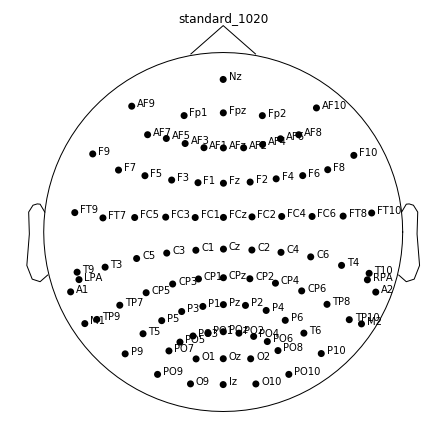

How long shall the transform window be (in secs)?: 2
How many seconds will be overlapped?: 1
How long shall the spectrogram window be (in secs)?: 2
How many seconds will be overlapped?: 1
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 60 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 5.00, 60.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 49.00, 51.00 Hz: -6.02, -6.02 dB

EEG data marked as already having the desired reference. Preventing automatic future re-referencing to an average reference.
Creating RawArray with float64 data, n_channels=4, n_times=320697
    Range : 0 ... 320696 =      0.00

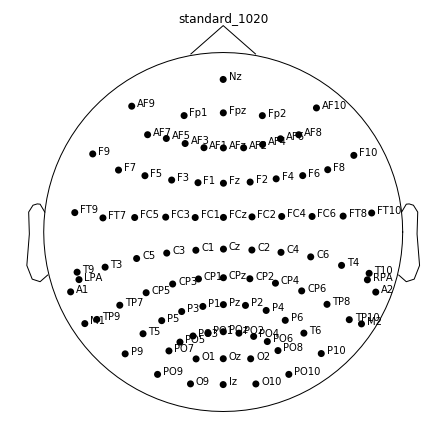

How long shall the transform window be (in secs)?: 2
How many seconds will be overlapped?: 1
How long shall the spectrogram window be (in secs)?: 2
How many seconds will be overlapped?: 1


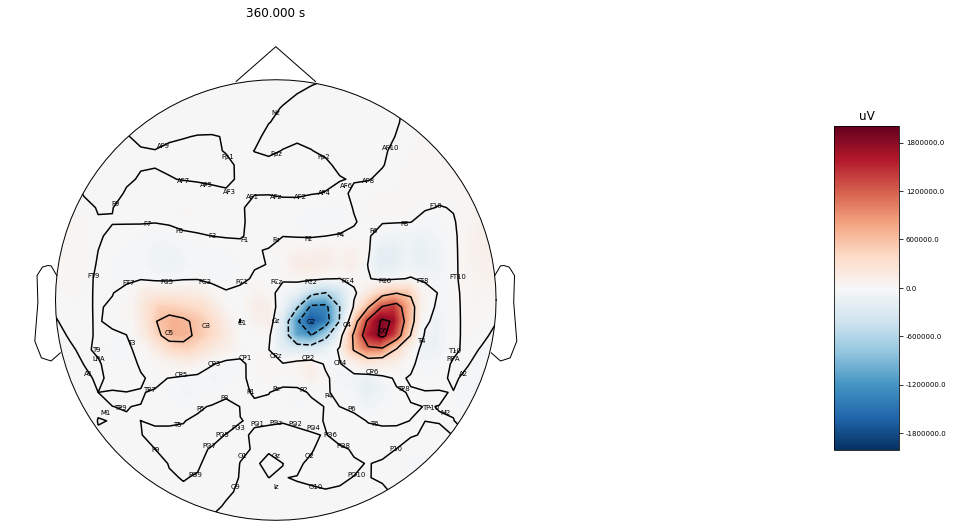

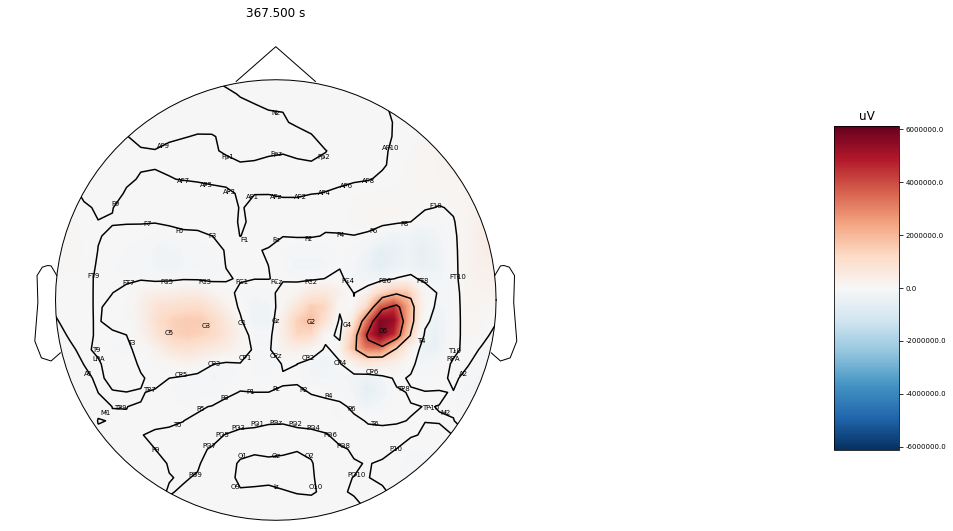

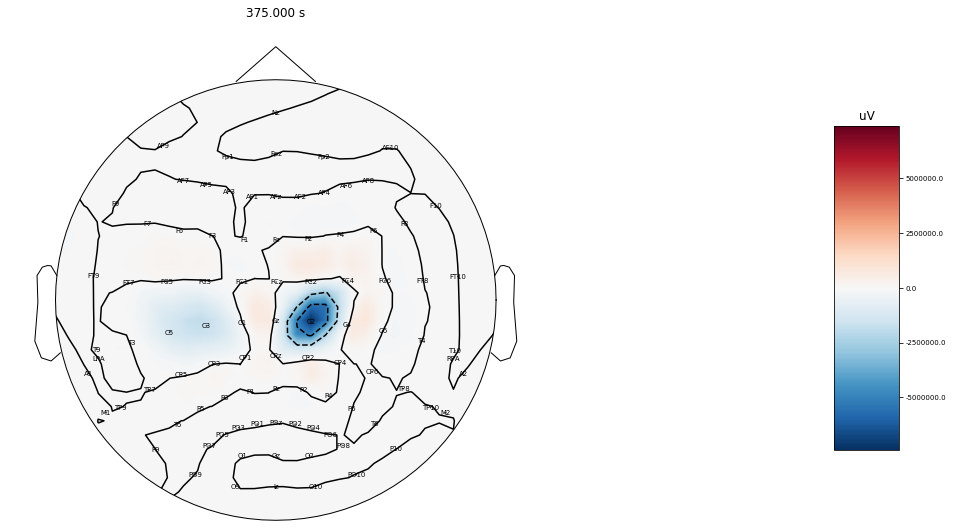

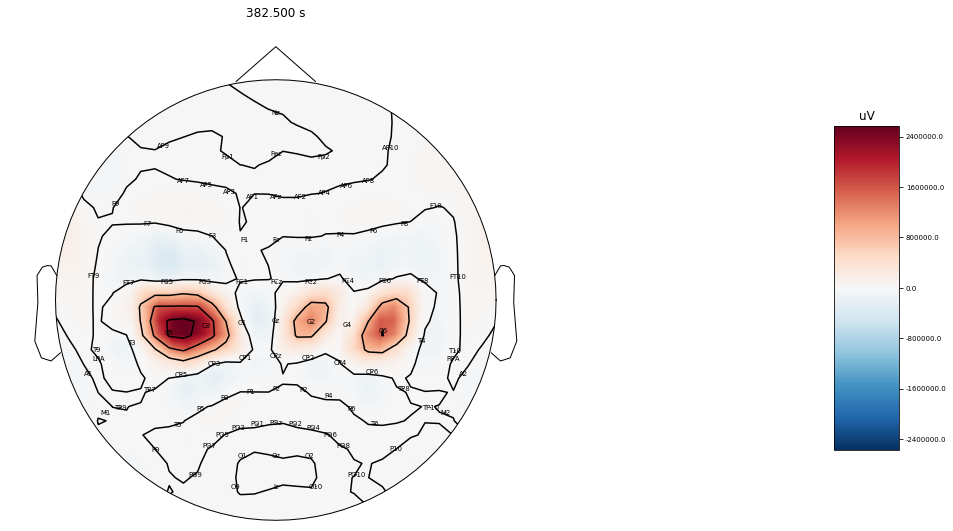

    'data': [{'colorscale': 'Viridis',
              'type': 'heatmap',
        …

    'data': [{'colorscale': 'Viridis',
              'type': 'heatmap',
        …

    'data': [{'colorscale': 'Viridis',
              'type': 'heatmap',
        …

    'data': [{'colorscale': 'Viridis',
              'type': 'heatmap',
        …

,Ojos Abiertos,Ojos Cerrados,Rojo 20Hz Con Estimulación,Rojo 20Hz Sin Estimulación,Rojo 25Hz Con Estimulación
Ch1 vs Ch1,1.000000,1.000000,1.000000,1.000000,1.000000
Ch1 vs Ch2,0.324001,0.316324,0.454545,0.263858,0.399047
Ch1 vs Ch3,0.469942,0.551608,0.555985,0.521676,0.599047
Ch1 vs Ch4,0.583208,0.673396,0.604559,0.652850,0.659097
Ch2 vs Ch1,0.324001,0.316324,0.454545,0.263858,0.399047
Ch2 vs Ch2,1.000000,1.000000,1.000000,1.000000,1.000000
Ch2 vs Ch3,0.496935,0.432105,0.991439,0.453954,0.530950
Ch2 vs Ch4,0.598273,0.577146,0.740627,0.524055,0.654015
Ch3 vs Ch1,0.469942,0.551608,0.555985,0.521676,0.599047
Ch3 vs Ch2,0.496935,0.432105,0.991439,0.453954,0.530950


,Ojos Abiertos,Ojos Cerrados,Rojo 20Hz Con Estimulación,Rojo 20Hz Sin Estimulación,Rojo 25Hz Con Estimulación
Ch1 vs Ch1,1.000000,1.000000,1.000000,1.000000,1.000000
Ch1 vs Ch2,0.127475,0.198993,0.258186,0.169037,0.190389
Ch1 vs Ch3,0.182031,0.328861,0.386260,0.265120,0.296689
Ch1 vs Ch4,0.280057,0.412512,0.474545,0.448694,0.455899
Ch2 vs Ch1,0.127475,0.198993,0.258186,0.169037,0.190389
Ch2 vs Ch2,1.000000,1.000000,1.000000,1.000000,1.000000
Ch2 vs Ch3,0.227738,0.237432,0.976436,0.252147,0.264161
Ch2 vs Ch4,0.326238,0.372009,0.447248,0.333752,0.330137
Ch3 vs Ch1,0.182031,0.328861,0.386260,0.265120,0.296689
Ch3 vs Ch2,0.227738,0.237432,0.976436,0.252147,0.264161


In [104]:
X_pd, signalname, col_names, col_types, usecols, skiprows, sep = load_signal()

chan_pos, chan_quant, chan_selecc, active_chan_quant, active_chan_names, active_chan_pos = chan_config(col_names, col_types)

X_chan, X_accel, X_tag = pd_toarray(X_pd)

sample_rate = find_samplerate(X_pd)

X_mneRaw = array_tomneRaw(X_chan)

int_ini, int_end, int_names, int_quant = interval_choice() 

while True:

    filt_type, filt_order, fq_lo, fq_hi, fq_no, cheby_rs , cheby_rp = preproc_params() 

    X_mneProc,  fq_sub = sgn_preproc(X_mneRaw)
    
    int_ini_sample, int_end_sample = interval_sec_tosample()
    
    X_mneProc = sgn_reref(X_mneProc)
    
    ica_opt = yn_quest("Would you like to apply an ICA Method?")
    
    if ica_opt == "Yes" or ica_opt == "yes":
        X_mneProc =  sgn_ica(X_mneProc)
    
    alt_mneEvoked = array_tomneEvoked(X_mneProc.get_data(), zeros_fill = True) #como mne.Evoked no tiene notch filter no le podemos aplicar sgn_preproc, así que construimos el evoked con la mneProc (señal procesada)
    
    #FFT_matrixRaw = sgn_fft(X_mneRaw.get_data())

    FFT_matrixProc = sgn_fft(X_mneProc.get_data())

    Spec_matrixProc = sgn_spec(X_mneProc.get_data())

    reset = plot_sgn()
    
    if reset == False:
        break

Rho_pd , Pval_pd = sgn_correlation ()

Coh_pd = sgn_coherence()